## Random Forest

Author: Elisa Warner
Created: 4/16/2019

Purpose: Check results of SVM against stock data

## Confusion Table Function

In [630]:
###########################
## Create confusion table
###########################

import matplotlib
import matplotlib.pyplot as plt

def prediction_box(predictions, ground_truth):
    ## results
    result = {'tp':0, 'fp':0, 'tn':0, 'fn':0}

    for i in range(len(predictions)):
        #print(pred_test[i], y[i])
        if predictions[i] == ground_truth[i] and ground_truth[i] == 1:
            result['tp'] = result.get('tp', 0) + 1
        elif predictions[i] == ground_truth[i] and ground_truth[i] == 0:
            result['tn'] = result.get('tn', 0) + 1
        elif predictions[i] != ground_truth[i] and ground_truth[i] == 1:
            result['fn'] = result.get('fn', 0) + 1
        else:
            result['fp'] = result.get('fp', 0) + 1

    m = np.array([[result['tp'], result['fn']],[result['fp'],result['fn']]])
    fig, ax = plt.subplots()
    im = ax.imshow(m, cmap='Pastel1')
    
    for i in range(m.shape[0]):
        for j in range(m.shape[1]):
            plt.text(j, i, "{:.2f}".format(m[i,j]), ha="center", va="center")
            plt.title('Predictions for Test Set')
            ax.set_xticks([0, 1])
            ax.set_yticks([0, 1])
            ax.set_xticklabels([1, 0])
            ax.set_yticklabels([1, 0])
            plt.ylabel('Ground Truth')
            plt.xlabel('Prediction')

### Remove Missing

In [631]:
def remove_missing(df):
    for col in list(df):
        colvals = df[col].values
        new_colvals = []
        for i in range(len(colvals)):
            if colvals[i] == '.':
                print('Missing found')
                new_colvals.append(colvals[i-1])
            elif pd.isnull(colvals[i]):
                print('nan found')
                new_colvals.append(colvals[i-1])
            else:
                new_colvals.append(colvals[i])
        df[col] = new_colvals
    
    return df

In [632]:
def remove_missing_horz(df):
    new_df = pd.DataFrame()
    for i in range(df.shape[0]):
        row = list(df.iloc[i].values)

        if '.' in row:
            idx_list = [i for i in range(len(row)) if row[i] == ('.')]
            for idx in idx_list:
                row[idx] = row[idx - 1]

        idx_list = [i for i in range(len(row)) if pd.isnull(row[i]) == True]
        for idx in idx_list:
            row[idx] = row[idx - 1]
            
        new_df = new_df.append(pd.DataFrame(row).T, ignore_index = True)
    
    return new_df

## 1. Load Data

In [633]:
#!pip3 install -U scikit-learn scipy matplotlib

In [657]:
import pandas as pd
from sklearn import svm
import numpy as np

In [658]:
file1 = "Combined_Sets_from_Revised_3_Label1.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

(7120, 219)

In [659]:
train_pd = train_pd[4182:6182]

train = np.array(train_pd)
train.shape

(2000, 219)

In [660]:
train = train[:,1:] # drop date
train

array([[1.0, 846.2999880000001, 4.731, ..., 0.0, 0.0, 9.0],
       [1.0, 851.9799800000001, 4.743, ..., 0.0, 0.0, 9.0],
       [1.0, 864.7999880000001, 4.86, ..., 0.0, 0.0, 9.0],
       ...,
       [0.0, 1256.079956, 2.43, ..., 0.0, 0.0, 11.0],
       [0.0, 1262.089966, 2.399, ..., 0.0, 0.0, 11.0],
       [0.0, 1259.819946, 2.35, ..., 0.0, 0.0, 11.0]], dtype=object)

In [661]:
train_pd

,Date,Label1_m30,main0,main1,main2,main3,main4,main5,main6,main7,...,google_hits58,google_hits59,google_hits60,google_hits61,google_hits62,google_hits63,google_hits64,google_hits65,google_hits66,google_hits67
4182,9/4/07,1.0,846.299988,4.731,0.121541,0.615738,0.120557,851.979980,4.743,0.123621,...,9.0,14.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,9.0
4183,9/5/07,1.0,851.979980,4.743,0.123621,0.615495,0.123788,864.799988,4.860,0.128473,...,9.0,14.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,9.0
4184,9/6/07,1.0,864.799988,4.860,0.128473,0.615304,0.129810,840.960022,4.790,0.119039,...,9.0,14.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,9.0
4185,9/7/07,1.0,840.960022,4.790,0.119039,0.612514,0.116143,841.369995,4.776,0.114612,...,9.0,14.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,9.0
4186,9/10/07,1.0,841.369995,4.776,0.114612,0.609893,0.109613,840.650024,4.778,0.119441,...,9.0,14.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,9.0
4187,9/11/07,1.0,840.650024,4.778,0.119441,0.602051,0.119028,825.039978,4.732,0.113085,...,9.0,14.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,9.0
4188,9/12/07,1.0,825.039978,4.732,0.113085,0.601702,0.109298,812.619995,4.706,0.107917,...,9.0,14.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,9.0
4189,9/13/07,1.0,812.619995,4.706,0.107917,0.601324,0.101206,815.429993,4.600,0.104299,...,9.0,14.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,9.0
4190,9/14/07,1.0,815.429993,4.600,0.104299,0.598976,0.097331,835.179993,4.673,0.111418,...,9.0,14.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,9.0
4191,9/17/07,1.0,835.179993,4.673,0.111418,0.596720,0.108406,835.750000,4.634,0.106029,...,9.0,14.0,0.0,1.0,7.0,4.0,0.0,0.0,0.0,9.0


## 2. Time-Series Cross validation

In [665]:
def time_cross(array, time_shift = 180, size_train_set = 365, size_val_set = 100, set_shift = 0):
    np.random.seed(100)
    label_idx = 0

    train_size = train.shape
    j = 0
    group = 1
    end = train_size[0]
    trainDataPartition = [] # list
    valDataPartition = []

    #print(size_train_set, size_val_set, train_size[0])
    while j + (size_train_set + size_val_set + set_shift) < train_size[0]:
        trainset = []
        valset = []

        trainset = train[j:j+size_train_set, :] # array
        valset = train[j+size_train_set+1+set_shift:j+size_train_set+size_val_set+set_shift, :]

        trainDataPartition.append(trainset)
        valDataPartition.append(valset)
    
        group = group+1;
        j = j + time_shift


    # make last set -- decide if you want to throw out or adjust this set
    trainset = train[j:j+size_train_set, :]
    valset = train[j+size_train_set+1+set_shift:end, :]
    
    trainDataPartition.append(trainset)
    valDataPartition.append(valset)

    
    ### Optional: stratify
    revised_trainDataPartition = []
    for i in range(len(trainDataPartition)):
        trainset = trainDataPartition[i]
        #print(trainset)
        records = trainset[:,0] # record of labels
        #print(sum(records == 1), sum(records == 0))
        if sum(records == 1) == 0 or sum(records == 0) == 0:
            revised_trainDataPartition.append(np.nan)
        elif sum(records == 1) > sum(records == 0):
            while sum(records == 1) >= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                #print(r)
                if records[r] == 1:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
        else:
            while sum(records == 1) <= 1.3 * sum(records == 0):
                r = round(np.random.rand() * (trainset.shape[0]-1))
                if records[r] == 0:
                    trainset = np.delete(trainset, r, 0)
                    records = np.delete(records, r)

            revised_trainDataPartition.append(trainset)
        #print(sum(records == 1), sum(records == 0))

    group = len(revised_trainDataPartition)
    print(group)
    
    return revised_trainDataPartition, valDataPartition, group

In [666]:
trainDataPartition, valDataPartition, group = time_cross(train, 100, 260, 100, 30)
print(len(trainDataPartition), len(valDataPartition))

18
18 18


In [669]:
valDataPartition[17]

array([[0.0, 1242.680054, 2.3930000000000002, ..., 0.0, 0.0, 13.0],
       [0.0, 1238.329956, 2.278, ..., 0.0, 0.0, 11.0],
       [0.0, 1245.189941, 2.231, ..., 0.0, 0.0, 11.0],
       ...,
       [0.0, 1256.079956, 2.43, ..., 0.0, 0.0, 11.0],
       [0.0, 1262.089966, 2.399, ..., 0.0, 0.0, 11.0],
       [0.0, 1259.819946, 2.35, ..., 0.0, 0.0, 11.0]], dtype=object)

## 3. Random Forest Implementation
No normalization necessary for Random Forest

In [670]:
##############################################################################
### Try Random Forest Classifier

import sklearn.model_selection
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [671]:
def rf(train_list, val_list, group):
    splits = group
    score = []

    #kf = sklearn.model_selection.KFold(n_splits=splits, random_state = 10, shuffle = True)
    #kf.get_n_splits(features)

    data_size = trainDataPartition[0].shape

    for idx in range(len(trainDataPartition)-1):
            # print("TRAIN:", train_index, "TEST:", test_index)
            try:
                X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
                y_train = y_train.astype('int')
                #print(X_train)
                X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
                y_test = y_test.astype('int')
                print('train:', sum(y_train), len(y_train))
                print('test:', sum(y_test), len(y_test))

                # Fit the RF model
                clf = RandomForestClassifier(n_estimators=50, max_depth=1500, random_state=0)
                clf.fit(X_train, y_train)
            except:
                continue # nan
                
            # print predicitions
            pred = clf.predict(X_test)
            #print(pred)

            # add up AUROCs
            
            try:
                temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
                #temp_score = sklearn.metrics.accuracy_score(y_test,pred)
                #score = score + sklearn.metrics.accuracy_score(y_test, pred)
                #temp_score = sum([1 for i in range(len(pred)) if pred[i] == y_test[i]]) / len(pred)
                score.append(temp_score)
                print(temp_score)
            except:
                pass


    # calculate average
    score = np.mean(score)
    print("Averaged Score is: %0.4f" % score, splits)


    # print(clf.feature_importances_)
    
    return score

In [672]:
print('groups', group)
rf(valDataPartition, trainDataPartition, group)

groups 18
train: 91 160
test: 56 99
0.3438538205980066
train: 100 176
test: 86 99
0.32379248658318427
train: 143 260
test: 50 99
0.5
train: 115 204
test: 39 99
0.5083333333333333
train: 127 225
test: 59 99
0.5
train: 114 201
test: 72 99
0.5
train: 137 243
test: 35 99
0.8035714285714285
train: 127 225
test: 72 99
0.6018518518518519
train: 133 236
test: 36 99
0.32738095238095233
train: 143 260
test: 24 99
0.6633333333333333
train: 121 214
test: 38 99
0.403364969801553
train: 89 157
test: 70 99
0.46995073891625616
train: 106 187
test: 58 99
0.5
train: 139 246
test: 60 99
0.6692307692307693
train: 131 232
test: 63 99
0.4087301587301587
train: 115 204
test: 55 99
0.4909090909090909
train: 142 252
test: 52 99
0.5673076923076923
Averaged Score is: 0.5048 18


0.5048006250910358

Hyperparameter Test

In [643]:
### Test
# time_shift, size_train_set, size_val_set

time_shift = [1] # smaller time shift is better, smaller training set, smaller val set 0, 50, 100, 126, 252, 504
# 504 252 50 0.61268998
size_train_set = [100, 252, 410]
size_val_set = [50, 100, 260] # predict a month ahead (shift labels)

score_matrix = np.zeros((len(time_shift), len(size_train_set), len(size_val_set)))

for i in range(len(time_shift)):
    for j in range(len(size_train_set)):
        for k in range(len(size_val_set)):
            time_shift = size_val_set[k]
            print(time_shift, size_train_set[j], size_val_set[k])
            trainDataPartition, valDataPartition, group = time_cross(train, time_shift, size_train_set[j], size_val_set[k], 30)

            #time_shift[i]
            score_matrix[i][j][k] = rf(valDataPartition, trainDataPartition, group)

print(np.argmax(score_matrix, axis = 1))
print(score_matrix)
#0.61268998 Didn't work so well with Label 2
# Perfomed well with predicting next day with Google Trends 0.8975, best was 0.96

50 100 50
38
train: 28 49
test: 25 49
0.5
train: 42 74
test: 19 49
0.5
train: 42 74
test: 3 49
0.4492753623188406
train: 26 45
test: 32 49
0.5
train: 31 54
test: 18 49
0.5403225806451613
train: 38 67
test: 49 49
train: 49 87
test: 39 49
0.5
train: 31 55
test: 24 49
0.35083333333333333
train: 18 32
test: 31 49
0.6209677419354839
train: 44 78
test: 25 49
0.5
train: 41 72
test: 8 49
0.5
train: 54 100
test: 27 49
0.5
train: 40 70
test: 28 49
0.5
train: 33 58
test: 39 49
0.5
train: 41 73
test: 41 49
0.5
train: 23 41
test: 6 49
0.5
train: 46 82
test: 29 49
0.6025862068965517
train: 44 77
test: 42 49
0.6547619047619048
train: 46 81
test: 22 49
0.553030303030303
train: 42 75
test: 43 49
0.5
train: 35 62
test: 0 49
train: 55 100
test: 14 49
0.5
train: 33 58
test: 12 49
0.5878378378378379
train: 20 35
test: 15 49
0.5
train: 17 30
test: 22 49
0.5
train: 39 68
test: 30 49
0.668421052631579
train: 38 67
test: 32 49
0.5
train: 46 81
test: 25 49
0.5425
train: 32 57
test: 30 49
0.3771929824561403
trai

In [644]:
t = np.max(score_matrix, axis = 1)
#print(np.argmax(t, axis = 1))
t

array([[0.54933226, 0.55088371, 0.55871166]])

# Look for Feature Importances

In [606]:
trainDataPartition, valDataPartition, group = time_cross(train, 25, 252, 50, 30) #10 252 100 Draft_Google_shorter 0.8795

68


In [645]:
splits = group
score_list = []
indices = []
pred_labels = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=100, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
        pred_labels.append(pred)
        #print(pred)
    except:
        continue #np.nan
        
    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass


# calculate average
score = np.mean(score_list)
print("Averaged Score is: %0.4f" % score, splits)

train: 173 306
test: 129 259
0.6609719737626714
train: 228 404
test: 163 259
0.5059752044989775
train: 209 410
test: 125 259
0.6232537313432835
train: 228 410
test: 113 259
0.5010001212268154
train: 165 291
test: 164 259
0.5435173299101412
Averaged Score is: 0.5669 6


Plot the accuracy through time

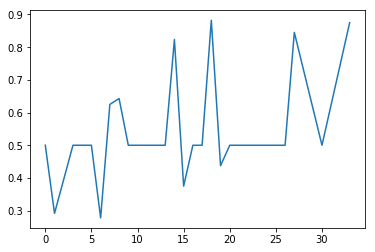

In [605]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(indices, score_list)
plt.show()

Which features are important during the time when the datasets are accurate?

In [402]:
indices = [x for x in range(len(score_list)) if score_list[x] > 0.75]
importance = np.array([])
count = 0

for idx in range(1220, 1235): # for several months of 2012, May - end of November, 1180, 1281
    # run random forest
    try:

        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')

        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
    
        # Fit the RF model
        clf = RandomForestClassifier(n_estimators=20, max_depth=1500, random_state=0) # previously 7
        clf.fit(X_train, y_train)

        # print predicitions
        pred = clf.predict(X_test)
    
        if not importance.any():
            print('hi')
            importance = clf.feature_importances_
        else:
            importance = importance + clf.feature_importances_

        count+=1
    except:
        continue #np.nan

    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score_list.append(temp_score)
        indices.append(idx)
        print(temp_score)
    except:
        pass

hi
0.8604651162790697
0.9166666666666667
0.9878048780487805
0.9125
0.9230769230769231
0.9078947368421053
0.9189189189189189
0.8888888888888888
0.9
0.8823529411764706
0.9545454545454546
0.953125
0.8870967741935484
0.8666666666666667
0.8793103448275862


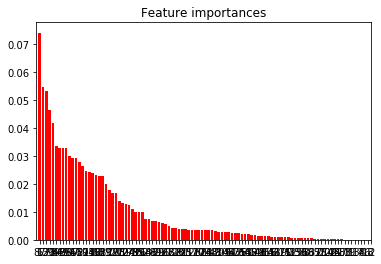

In [403]:
importance = importance / count
feature_indices = np.argsort(importance)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importance[feature_indices],
       color="r", align="center") # X_train.shape[1]
plt.xticks(range(X_train.shape[1]), feature_indices) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [ ]:
name = 'Combined_Sets_from_Revised_3.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(feature_indices)-1):
    idx = feature_indices[i]
    print(listoffeatures[idx], importance[idx])
    if i <= 25:
        shortlist.append(listoffeatures[idx])
shortlist

# Feature Importance

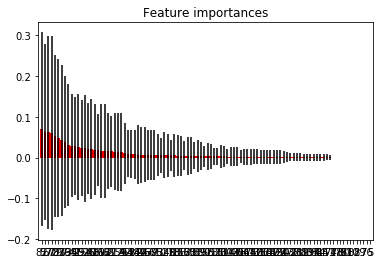

In [313]:
# Create a graph of fetaure importances

import matplotlib.pyplot as plt

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest (ERROR HIDDEN, TOO BIG)
plt.figure()
plt.title("Feature importances")
plt.bar(range(100), importances[indices[0:100]],
       color="r", yerr=std[indices[0:100]], align="center") # X_train.shape[1]
plt.xticks(range(100), indices[0:100]) #X_train.shape[1]
plt.xlim([-1, 100]) #X_train.shape[1]]) 
plt.show()

In [274]:
print(len(clf.feature_importances_))
print(len(list(train_pd)[1:]))

217
218


In [275]:
name = 'Combined_Sets_from_Revised_3.csv'
df = pd.read_csv(name)
df = df.drop(['Date'], axis = 1)

In [ ]:
# Show all the list of features and their respective importances

#listoffeatures = list(train_pd)[1:]
listoffeatures = list(df)
shortlist = []

print('Top Features listed by Importance')

for i in range(len(indices)-1):
    idx = indices[i]
    print(listoffeatures[idx], importances[idx])
#    if i <= 50:
#        shortlist.append(listoffeatures[i])

# SVM

In [280]:
trainDataPartition, valDataPartition, group = time_cross(train, 1, 150, 50) #10 252 100 Draft_Google_shorter 0.8795

1800


In [687]:
test = pd.DataFrame(valDataPartition[1])
test

,0,1,2,3,4,5,6,7,8,9,...,208,209,210,211,212,213,214,215,216,217
0,1,446.45,2.799,-0.136085,1.00822,-0.162738,441.13,2.945,-0.139883,1.01377,...,14,7,1,1,8,11,0,0,0,58
1,1,441.13,2.945,-0.139883,1.01377,-0.167032,433.96,2.978,-0.14664,1.01885,...,14,7,1,1,8,11,0,0,0,58
2,1,433.96,2.978,-0.14664,1.01885,-0.173156,424.88,3.041,-0.150028,1.02423,...,14,7,1,1,8,11,0,0,0,58
3,1,424.88,3.041,-0.150028,1.02423,-0.176169,404.26,2.919,-0.168569,1.02876,...,14,7,1,1,8,11,0,0,0,58
4,1,404.26,2.919,-0.168569,1.02876,-0.192231,401.44,2.938,-0.170677,1.03613,...,14,7,1,1,8,11,0,0,0,58
5,1,401.44,2.938,-0.170677,1.03613,-0.193081,411.36,3.011,-0.162203,1.04287,...,14,7,1,1,8,11,0,0,0,58
6,1,411.36,3.011,-0.162203,1.04287,-0.184407,393.34,2.819,-0.174468,1.0494,...,31,6,1,1,6,11,0,0,0,75
7,1,393.34,2.819,-0.174468,1.0494,-0.193118,393.85,2.828,-0.172764,1.05578,...,31,6,1,1,6,11,0,0,0,75
8,1,393.85,2.828,-0.172764,1.05578,-0.190422,389.61,2.886,-0.178188,1.06025,...,31,6,1,1,6,11,0,0,0,75
9,1,389.61,2.886,-0.178188,1.06025,-0.195282,414.69,2.982,-0.156437,1.06629,...,31,6,1,1,6,11,0,0,0,75


In [680]:
splits = group
score = []
good_sets = []
gammas = []

data_size = trainDataPartition[0].shape

for idx in range(len(trainDataPartition)-1):
    try:
        # print("TRAIN:", train_index, "TEST:", test_index)
        X_train, y_train = trainDataPartition[idx][:,1:data_size[1]+1], trainDataPartition[idx][:,0]
        y_train = y_train.astype('int')
        #print(X_train)
        X_test, y_test = valDataPartition[idx][:,1:data_size[1]+1], valDataPartition[idx][:,0]
        y_test = y_test.astype('int')
        print('train:', sum(y_train), len(y_train))
        print('test:', sum(y_test), len(y_test))
        #print(1 / (X_train.shape[1] * X_train.var()))
        # Fit the RF model

        #gamma =  (1 / (X_train.shape[1] * X_train.var()))
        clf = sklearn.svm.SVC(C=.7, kernel='rbf', gamma='scale') # previously 7
        clf.fit(X_train, y_train)
    except:
        continue

    # print predicitions
    pred = clf.predict(X_test)
    #print(pred)

    # add up AUROCs
            
    try:
        temp_score = sklearn.metrics.roc_auc_score(y_test, pred)
        score.append(temp_score)
        print(temp_score)
        if temp_score > 0.7:
            good_sets.append(idx)
            gammas.append(1 / (X_train.shape[1] * X_train.var()))
    except:
        pass


# calculate average
score = np.mean(score)
print("Averaged Score is: %0.4f" % score, splits)

train: 91 160
test: 56 99
0.5
train: 100 176
test: 86 99
0.5581395348837209
train: 143 260
test: 50 99
0.5
train: 115 204
test: 39 99
0.3288461538461539
train: 127 225
test: 59 99
0.6417372881355932
train: 114 201
test: 72 99
0.5
train: 137 243
test: 35 99
0.5
train: 127 225
test: 72 99
0.5
train: 133 236
test: 36 99
0.4305555555555556
train: 143 260
test: 24 99
0.605
train: 121 214
test: 38 99
0.3524590163934426
train: 89 157
test: 70 99
0.5
train: 106 187
test: 58 99
0.5
train: 139 246
test: 60 99
0.5
train: 131 232
test: 63 99
0.49404761904761907
train: 115 204
test: 55 99
0.7818181818181817
train: 142 252
test: 52 99
0.5
Averaged Score is: 0.5113 18


In [ ]:
good_sets

In [ ]:
pred_labels2 = []
for predlist in pred_labels:
    for x in range(len(predlist)):
        pred_labels2.append(predlist[x])
pred_labels2

# Test just one giant set
Why: Because if we can get more than 50%, we can get predictions for everything in the training set. Let's see if we can get some kind of "universal" model

In [614]:
file1 = "Combined_Sets_from_Revised_3_Label1.csv" #"Draft_Google_Shorter.csv" #Removed Missing

train_pd = pd.read_csv(file1)
train_pd.shape

(7120, 219)

In [615]:
train_pd = train_pd[6184:]

train = np.array(train_pd)
train.shape

(936, 219)

In [683]:
valDataPartition[7]

array([[1.0, 786.5599980000001, 2.908, ..., 0.0, 0.0, 26.0],
       [1.0, 789.5, 2.891, ..., 0.0, 0.0, 26.0],
       [1.0, 783.119995, 2.944, ..., 0.0, 0.0, 26.0],
       ...,
       [1.0, 683.849976, 1.9669999999999999, ..., 1.0, 1.0, 36.0],
       [1.0, 705.049988, 1.9580000000000002, ..., 1.0, 1.0, 36.0],
       [1.0, 706.179993, 1.996, ..., 1.0, 1.0, 36.0]], dtype=object)